In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library 
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications import VGG16

# To chain two different data augmented images for training
from itertools import chain

#  Distributed Computing
import tensorflow as tf


## 1.3 Parameter Setup for Model Training

In [2]:
BATCH_SIZE = 48

image_height = 299
image_width = 299


## Image Augmentation


In [3]:
# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )
print('Data Augmentation 2 was created')

data_generator_3 = ImageDataGenerator (rescale=1./255)


Data Augmentation 1 was created
Data Augmentation 2 was created


In [4]:
train_generator1 = data_generator_1.flow_from_directory(
    directory = r"D:\project\data\chest_xray\train", # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Data Augmentation 1 was used to generate train data set\n')



test_generator = data_generator_3.flow_from_directory(
    directory = r"D:\project\data\chest_xray\test", # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)



Found 5216 images belonging to 2 classes.
Data Augmentation 1 was used to generate train data set

Found 624 images belonging to 2 classes.


# 3. EDA

In [5]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


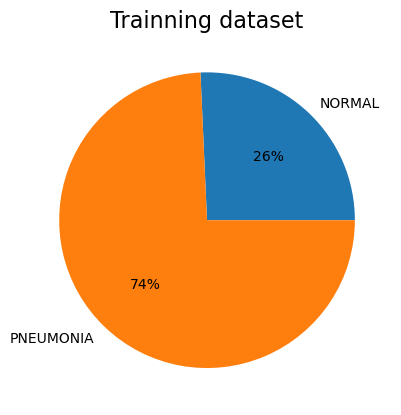

In [6]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [7]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in train_generator1.classes if label == 1]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of normal images:", len([label for label in test_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in test_generator.classes if label == 1]))
print()


Dataset Characteristics of Train Data Set:
Number of images: 5216
Number of normal images: 1341
Number of pneumonia images: 3875

Dataset Characteristics of Test Data Set:
Number of images: 624
Number of normal images: 234
Number of pneumonia images: 390



### Class Weights

In [8]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights


{0: 1.9448173005219984, 1: 0.6730322580645162}

### Image Samples

Train image data from Data Augmentation 1


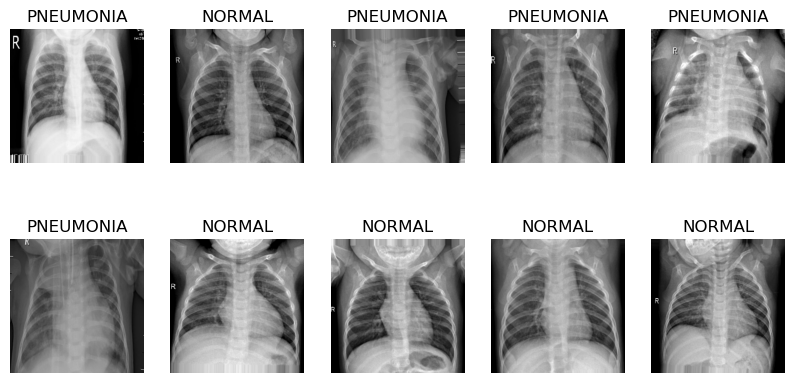

In [9]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[10, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

## VGG16


In [10]:

    # Load the pre-trained VGG16 model without the top classification layer
    base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_VGG16.layers:
        layer.trainable = False
    
    # Create a new model and add the VGG16 base model
    model_VGG16 = Sequential()
    model_VGG16.add(base_model_VGG16)

    # Add a fully connected layer and output layer for classification
    model_VGG16.add(GlobalAveragePooling2D())
    model_VGG16.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.4))
    model_VGG16.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.2))
    model_VGG16.add(Dense(2, activation='softmax'))

    # Model summary
    print("Model Summary (VGG16):")
    model_VGG16.summary()
    print()
    

Model Summary (VGG16):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                 

In [11]:
train_data = train_generator1

# Define early stopping criteria 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Compile the model
model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_VGG16 = model_VGG16.fit(train_data, epochs=3, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)


Epoch 1/3
109/109 [==============================] - 1492s 14s/step - loss: 0.5792 - accuracy: 0.8029 - val_loss: 0.4577 - val_accuracy: 0.8333
Epoch 2/3
109/109 [==============================] - 1658s 15s/step - loss: 0.3572 - accuracy: 0.8825 - val_loss: 0.4051 - val_accuracy: 0.8429
Epoch 3/3
109/109 [==============================] - 1665s 15s/step - loss: 0.2991 - accuracy: 0.9089 - val_loss: 0.3626 - val_accuracy: 0.8782


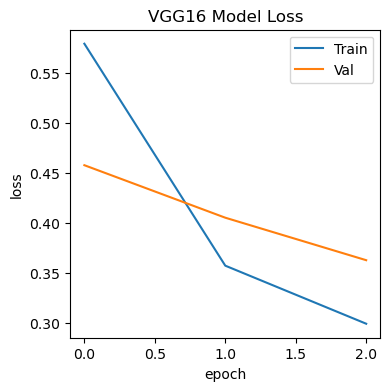

In [13]:
plt.figure(figsize=(4,4))
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

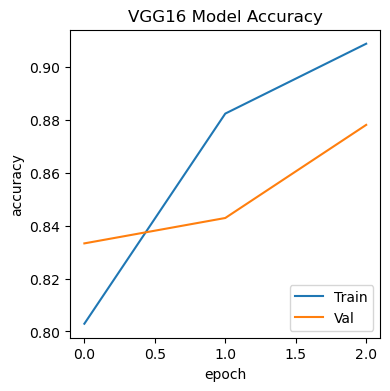

In [14]:
plt.figure(figsize=(4,4))
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [15]:
y_pred = model_VGG16.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

13/13 [==============================] - 168s 13s/step


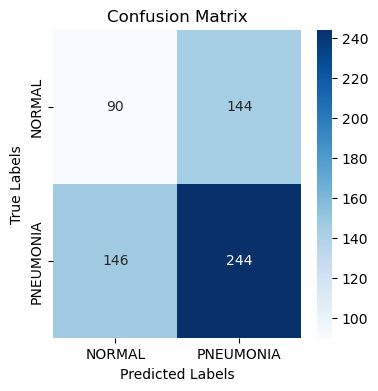

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
# Calculate the confusion matrix
confusion_mtx = confusion_matrix(true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# Generate the classification report
classification_rep = classification_report(true_classes, y_pred_classes, target_names=class_labels)

# Print the classification report
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.38      0.38      0.38       234
   PNEUMONIA       0.63      0.63      0.63       390

    accuracy                           0.54       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.54      0.54       624



In [12]:
# test the model
test_loss_VGG16, test_accuracy_VGG16 = model_VGG16.evaluate(test_generator, steps=len(test_generator))
print(f'test Loss: {test_loss_VGG16:.4f}')
print(f'test Accuracy: {test_accuracy_VGG16:.4f}')

13/13 [==============================] - 165s 13s/step - loss: 0.3626 - accuracy: 0.8782
test Loss: 0.3626
test Accuracy: 0.8782


2/2 [==============================] - 13s 4s/step


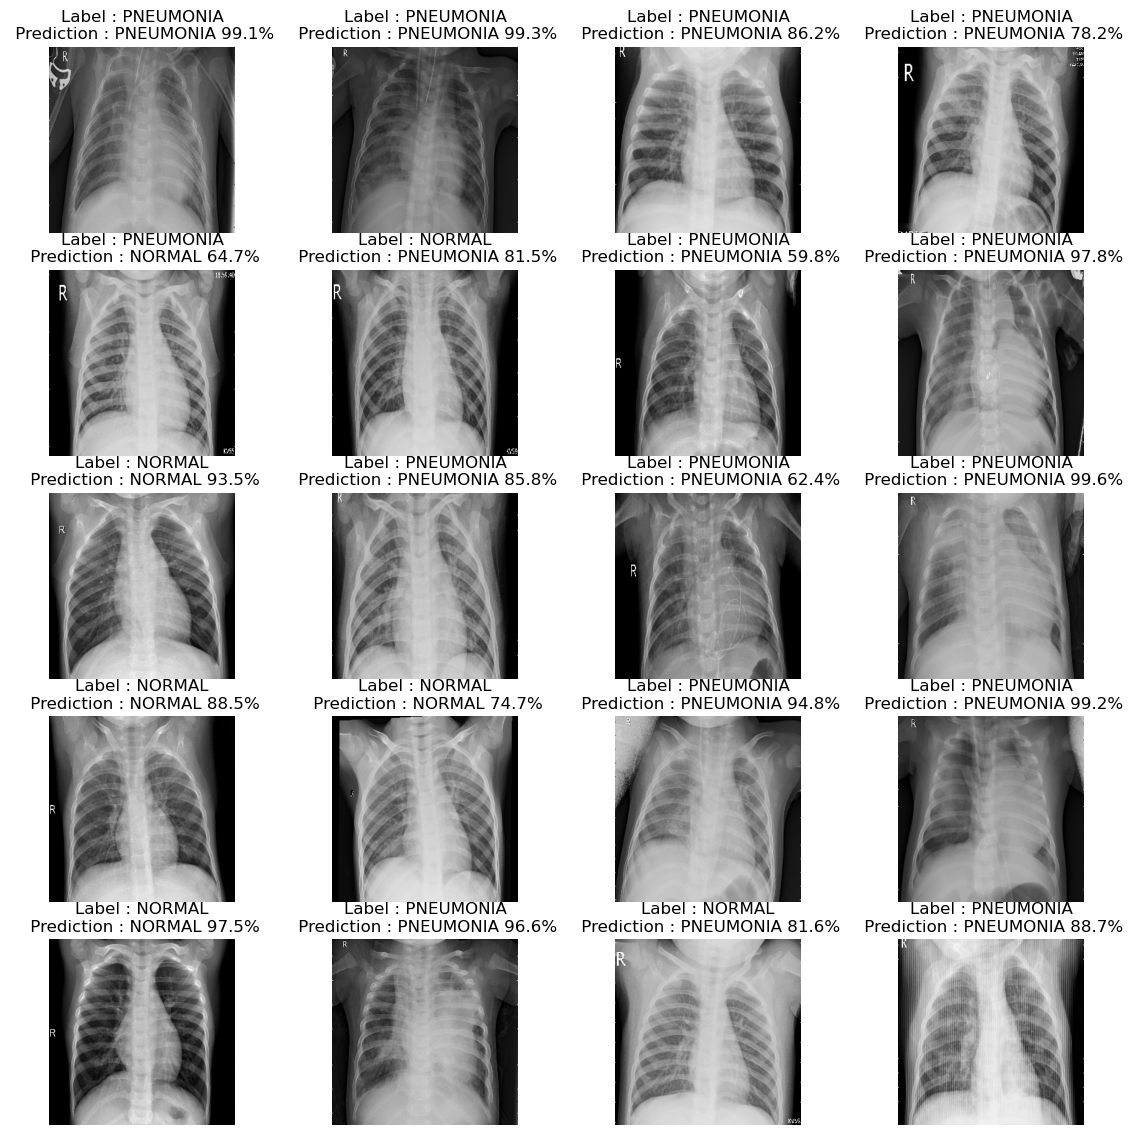

In [18]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_VGG16.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()